<a href="https://colab.research.google.com/github/Annie00000/Project/blob/main/%E5%BD%B1%E5%83%8F%E5%88%86%E9%A1%9E_%E7%9B%AE%E5%89%8D%E7%89%88%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 設定隨機種子以保持結果可重現性
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [3]:
import torch

# 設定GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [1]:
import tensorflow as tf
# 检查GPU并限制CPU使用
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [ ]:
# 限制CPU使用
tf.config.threading.set_inter_op_parallelism_threads(10)

## 套件

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

import os
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import time


## Load data

In [3]:
# 記錄開始時間
start_time = time.time()

# 讀取所有影像路徑和標籤
data_dir = '/content/drive/MyDrive/Colab Notebooks/eye_diseases/train/'
image_paths = []
labels = []

for class_folder in os.listdir(data_dir):
    class_folder_path = os.path.join(data_dir, class_folder)
    for file in os.listdir(class_folder_path):
        fpath = os.path.join(class_folder_path, file)
        image_paths.append(fpath)
        labels.append(class_folder)

# 計算讀取時間
data_loading_time = time.time() - start_time
print(f"Data loading time: {data_loading_time} seconds")

Data loading time: 0.14572429656982422 seconds


### 創建標籤轉換為數字的字典，建構DataFrame

In [4]:
# 將標籤轉換為數字
unique_labels = sorted(list(set(labels)))
label_to_index = {label: index for index, label in enumerate(unique_labels)}
indices = [label_to_index[label] for label in labels]

# 建立標籤查詢的DataFrame
label_df = pd.DataFrame(list(label_to_index.items()), columns=['Label', 'Index'])


### 切分為 訓練/驗證/測試集

In [6]:
# 切分訓練集、驗證集和測試集
train_paths, test_val_paths, train_indices, test_val_indices = train_test_split(image_paths, indices, test_size=0.3, shuffle=True, random_state=42)
val_paths, test_paths, val_indices, test_indices = train_test_split(test_val_paths, test_val_indices, test_size=0.5, shuffle=True, random_state=42)

### 可視化 訓練集 的圖片

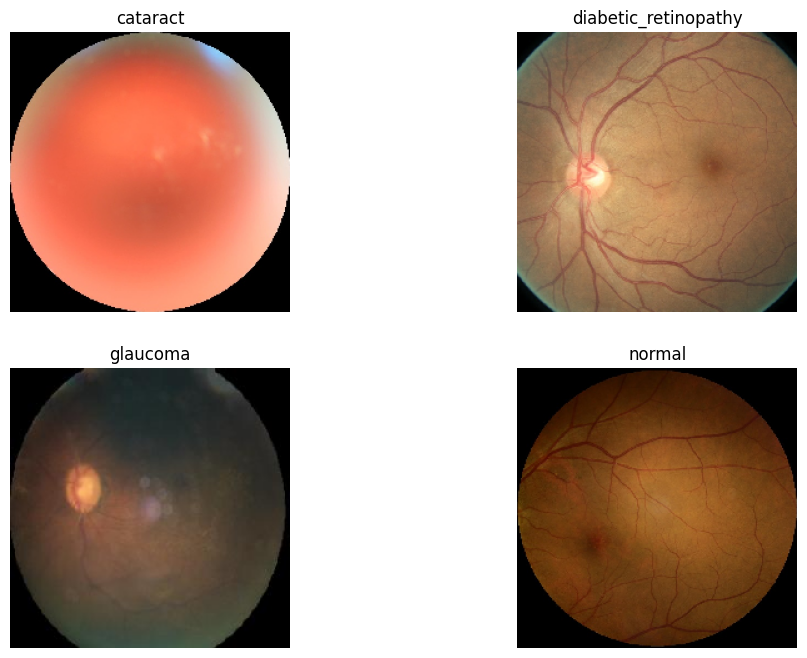

In [7]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 可視化訓練集中每個類別的隨機一張照片
target_size = (224,224)
plt.figure(figsize=(12, 8))
for i, label in enumerate(unique_labels):
    label_images = [path for path, lbl in zip(train_paths, train_indices) if lbl == label_to_index[label]]
    random_image_path = random.choice(label_images)
    img = load_img(random_image_path, target_size=target_size)  # 調整圖片大小
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.show()


### 資料增強

In [8]:
# 載入CSV檔案來獲取增強設置
augmentation_csv_path = '/content/drive/MyDrive/Colab Notebooks/eye_diseases/augmentation.csv'
augmentation_df = pd.read_csv(augmentation_csv_path)

# 創建一個字典來儲存每個類別的增強設置
#augmentation_dict = {row['label']: row.drop('label').to_dict() for _, row in augmentation_df.iterrows()}
augmentation_dict = {label_to_index[row['label']]: row.drop('label').to_dict() for _, row in augmentation_df.iterrows()}


In [9]:
augmentation_dict

{3: {'rotate 90': 0, 'rotate 180': 0, 'rotate 270': 0, '水平翻轉': 1, '垂直翻轉': 1},
 2: {'rotate 90': 0, 'rotate 180': 1, 'rotate 270': 0, '水平翻轉': 1, '垂直翻轉': 0},
 1: {'rotate 90': 1, 'rotate 180': 1, 'rotate 270': 1, '水平翻轉': 0, '垂直翻轉': 0},
 0: {'rotate 90': 1, 'rotate 180': 1, 'rotate 270': 1, '水平翻轉': 1, '垂直翻轉': 1}}

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array


# 自定義的數據增強函數
def apply_augmentation(image, category_index):

    # 獲取對應label的增強準則
    augmentation_settings = augmentation_dict[category_index]

    # 決定旋轉角度
    rotation_options = [0, 90, 180, 270]
    rotation_choices = [rotation_options[i] for i in range(1, 4) if augmentation_settings[f'rotate {rotation_options[i]}']]
    rotation_angle = random.choice(rotation_choices) if rotation_choices else 0
    '''
    rotation_choices：根據 augmentation_settings 中的設定，從 rotation_options 中選擇應用的旋轉角度。如果 rotate 90, rotate 180, rotate 270 中有任何一項被設為 1，相應的角度就會被加入到 rotation_choices 中。
    rotation_angle：從 rotation_choices 中隨機選擇一個角度作為旋轉角度。如果 rotation_choices 為空（即沒有旋轉設定為 1），則不進行旋轉（角度為0）。
    '''

    # 決定是否進行翻轉
    horizontal_flip = augmentation_settings['水平翻轉'] == 1
    vertical_flip = augmentation_settings['垂直翻轉'] == 1
    if horizontal_flip and vertical_flip:
        horizontal_flip = random.choice([True, False])
        vertical_flip = not horizontal_flip or random.choice([True, False])
        '''
        如果水平翻轉和垂直翻轉都被設定為 1，則隨機選擇是否進行水平翻轉，並基於這個選擇來決定是否進行垂直翻轉。這意味著有可能進行兩者中的一種，或同時進行兩者。
        '''

    # 應用數據增強
    datagen = ImageDataGenerator(
        rotation_range=rotation_angle,
        horizontal_flip=horizontal_flip,
        vertical_flip=vertical_flip
    )

    # 將圖像轉換為 Numpy 數組並獲取形狀
    image_array = img_to_array(image)
    image_array = image_array.reshape((1,) + image_array.shape)

    iterator = datagen.flow(image_array, batch_size=1)  # 通過 datagen.flow 產生一個迭代器，對單張圖像進行增強操作。
    return next(iterator)[0].astype('uint8')  # 使用 next(iterator)[0] 從迭代器中獲取增強後的圖像，並將其轉換為適當的數據類型（uint8）以供後續處理。

    #image = img_to_array(image).reshape((1,) + image.shape) # image 被轉換為 Numpy 數組，並重新調整形狀以適應數據生成器的需要



### 模型訓練

In [61]:
#### 版1 : 一般的
# 訓練數據生成器
def train_generator():
    for i in range(0, len(train_paths), batch_size):
        # 選取當前批次的路徑和對應的標籤索引
        batch_paths = train_paths[i: i+batch_size]
        batch_indices = train_indices[i : i+batch_size]
        # 加載和處理圖像，並應用數據增強
        batch_images = np.array([apply_augmentation(load_img(path, target_size=(224, 224)), index) for path, index in zip(batch_paths, batch_indices)])
         # 將標籤索引轉換為 one-hot 編碼的形式
        batch_labels = to_categorical(batch_indices, num_classes=len(unique_labels))

        # 使用 yield 語句返回一個包含當前批次的圖像數據和標籤的元組。這允許 train_generator 在每次被調用時返回一個批次的數據，而不需要一次加載整個數據集到內存中。)
        yield batch_images, batch_labels

# 驗證數據生成器
def validation_generator():
    for i in range(0, len(val_paths), batch_size):
        batch_paths = val_paths[i : i+batch_size]
        batch_indices = val_indices[i : i+batch_size]
         # 加载和处理图像，转换为适合模型输入的格式
        batch_images = np.array([img_to_array(load_img(path, target_size=(224, 224))) for path in batch_paths])
        batch_labels = to_categorical(batch_indices, num_classes=len(unique_labels))
        yield batch_images, batch_labels

In [11]:
#### 版2 : # 使用无限循环，确保生成器可以持续产生数据


# 训练数据生成器
def train_generator():
    while True:  # 使用无限循环，确保生成器可以持续产生数据
        for i in range(0, len(train_paths), batch_size):
            batch_paths = train_paths[i:i + batch_size]
            batch_indices = train_indices[i:i + batch_size]
            batch_images = np.array([apply_augmentation(load_img(path, target_size=(224, 224)), index) for path, index in zip(batch_paths, batch_indices)])
            batch_labels = to_categorical(batch_indices, num_classes=len(unique_labels))
            yield batch_images, batch_labels

# 验证数据生成器
def validation_generator():
    while True:
        for i in range(0, len(val_paths), batch_size):
            batch_paths = val_paths[i:i + batch_size]
            batch_indices = val_indices[i:i + batch_size]
            batch_images = np.array([img_to_array(load_img(path, target_size=(224, 224))) for path in batch_paths])
            batch_labels = to_categorical(batch_indices, num_classes=len(unique_labels))
            yield batch_images, batch_labels


In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import Callback

# 創建DenseNet模型
model = Sequential([
    DenseNet121(include_top=False, input_shape=(224, 224, 3), weights='imagenet'),
    Flatten(),
    Dense(len(unique_labels), activation='softmax')
])

# 編譯模型
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 設定回調
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
model_checkpoint = ModelCheckpoint('model_best.h5', save_best_only=True, monitor='val_loss', mode='min') # 可改成.keras格式('model_best.keras')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001, verbose=1)


callbacks = [early_stopping, model_checkpoint, reduce_lr]


In [13]:
from tensorflow.keras.utils import to_categorical

# 訓練模型
batch_size = 32
epochs = 10  # 可根據需要調整

# 開始訓練
training_start_time = time.time()
# 訓練模型
history = model.fit(
    train_generator(),
    steps_per_epoch=len(train_paths) // batch_size,
    validation_data=validation_generator(),
    validation_steps=len(val_paths) // batch_size,
    epochs=epochs,
    callbacks=callbacks
)


training_duration = time.time() - training_start_time
print(f"Total training time: {training_duration} seconds")

Epoch 1/10
93/93 [==============================] - ETA: 0s - loss: 1.6629 - accuracy: 0.7345

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


93/93 [==============================] - 189s 1s/step - loss: 1.6629 - accuracy: 0.7345 - val_loss: 4742.1704 - val_accuracy: 0.2766 - lr: 0.0010
Epoch 2/10
93/93 [==============================] - 80s 773ms/step - loss: 0.7563 - accuracy: 0.8311 - val_loss: 755.9292 - val_accuracy: 0.4750 - lr: 0.0010
Epoch 3/10
93/93 [==============================] - 71s 763ms/step - loss: 2.1047 - accuracy: 0.7590 - val_loss: 72704552.0000 - val_accuracy: 0.2766 - lr: 0.0010
Epoch 4/10
93/93 [==============================] - 66s 715ms/step - loss: 0.8377 - accuracy: 0.7944 - val_loss: 130281.8594 - val_accuracy: 0.4016 - lr: 0.0010
Epoch 5/10
93/93 [==============================] - 69s 745ms/step - loss: 0.4174 - accuracy: 0.8713 - val_loss: 1847.9889 - val_accuracy: 0.6734 - lr: 0.0010
Epoch 6/10
93/93 [==============================] - 68s 732ms/step - loss: 0.2596 - accuracy: 0.9070 - val_loss: 180.1365 - val_accuracy: 0.7047 - lr: 0.0010
Epoch 7/10
93/93 [==============================] - 66s

## 查看訓練結果

In [25]:
# 计算最终epoch的损失和准确率
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Train Loss: {final_train_loss}") #也是Best
print(f"Final Validation Loss: {final_val_loss}")
print(f"Final Train Accuracy: {final_train_accuracy}")
print(f"Final Validation Accuracy: {final_val_accuracy}")

Final Train Loss: 0.23539358377456665
Final Validation Loss: 3.2341976165771484
Final Train Accuracy: 0.9211324453353882
Final Validation Accuracy: 0.71875


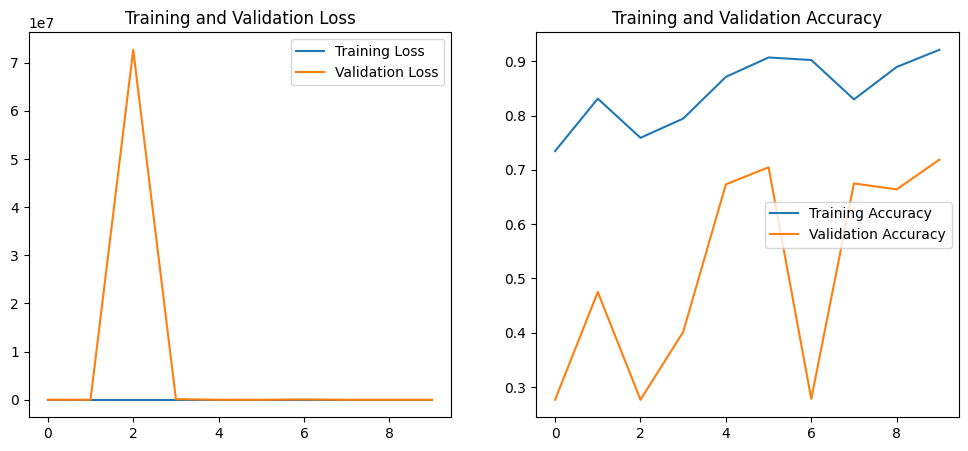

In [15]:
# 绘制训练损失和验证损失
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 绘制训练精度和验证精度
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

## 測試集結果

In [23]:
# 加载测试集图像
test_images = np.array([img_to_array(load_img(img_path, target_size=target_size)) for img_path in test_paths])
#test_images = test_images.astype('float32') # 可以不用(?)待確認

# 开始计时
test_start_time = time.time()

# 对测试集进行评估
test_loss, test_accuracy = model.evaluate(test_images, to_categorical(test_indices, num_classes=len(unique_labels)))

# 记录运行时间
test_duration = time.time() - test_start_time
print(f"Test Evaluation Time: {test_duration} seconds")

# 打印结果
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

21/21 [==============================] - 2s 90ms/step - loss: 7.5377 - accuracy: 0.6905
Test Evaluation Time: 3.49160099029541 seconds
Test Loss: 7.537746429443359
Test Accuracy: 0.6905131936073303


#### Confusion Table


21/21 [==============================] - 2s 88ms/step


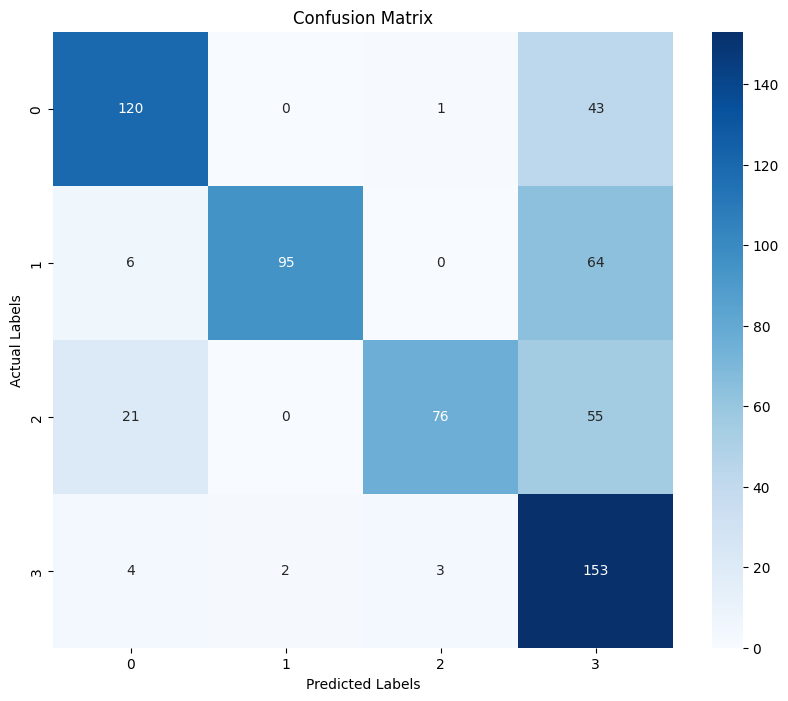

In [19]:
test_predictions = model.predict(test_images)
test_pred_labels = np.argmax(test_predictions, axis=1)

# 生成混淆矩阵
cm = confusion_matrix(test_indices, test_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

### 查看分錯的類別&其正確標籤

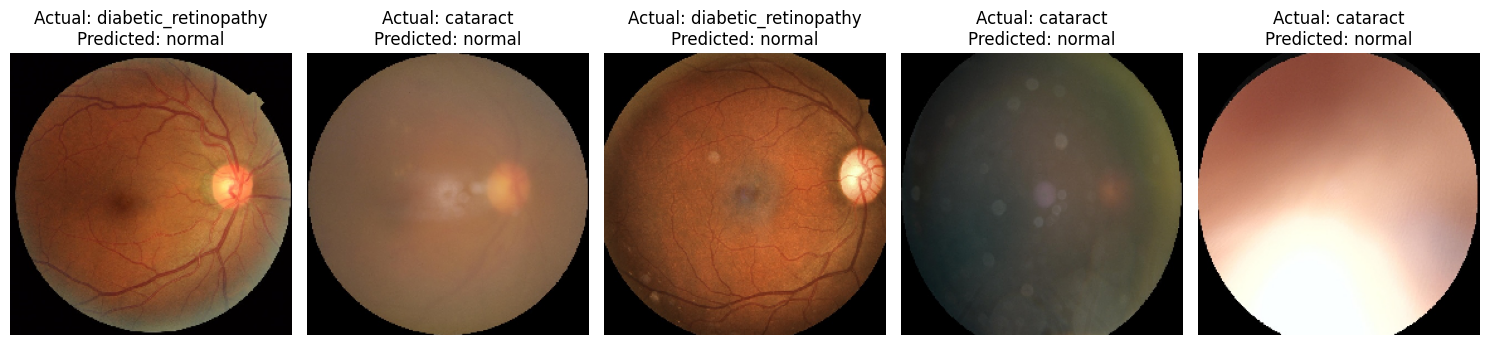

In [27]:
# 找到被错误分类的图片索引
misclassified_idxs = np.where(test_pred_labels != test_indices)[0]

# 选择展示的图片数量
num_samples = 5
sample_idxs = np.random.choice(misclassified_idxs, num_samples, replace=False)

# 展示被错误分类的图片
plt.figure(figsize=(15, 10))
for i, idx in enumerate(sample_idxs):
    img_path = test_paths[idx]
    img = load_img(img_path, target_size=target_size)
    actual_label = unique_labels[test_indices[idx]]
    predicted_label = unique_labels[test_pred_labels[idx]]

    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img)
    plt.title(f'Actual: {actual_label}\nPredicted: {predicted_label}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# 舊的部分

In [ ]:
from sklearn.model_selection import train_test_split
import os
import glob
import pandas as pd
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# 設定資料路徑和目標圖片大小
data_dir = '/content/drive/MyDrive/Colab Notebooks/eye_diseases/train/'
target_size = (224, 224)

# 讀取所有圖片路徑和標籤
image_paths = []
labels = []

for class_folder in os.listdir(data_dir):
    class_folder_path = os.path.join(data_dir, class_folder)
    for file in os.listdir(class_folder_path):  # 假設所有圖片都是jpg格式
        fpath = os.path.join(class_folder_path, file)
        image_paths.append(fpath)
        labels.append(class_folder)



In [ ]:
# 將標籤轉換為數字
label_to_index = dict((name, index) for index, name in enumerate(np.unique(labels)))
labels = np.array([label_to_index[label] for label in labels])

# 切分成訓練集、驗證集和測試集
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2,shuffle=True,random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.25)


In [ ]:
# 創建一個 DataFrame 從 label_to_index
label_to_index_df = pd.DataFrame(list(label_to_index.items()), columns=['Label', 'Index'])

# 將 DataFrame 寫入 CSV 檔案
#label_to_index_df.to_csv('label_to_index.csv', index=False)

# 確認已成功保存
print("Label to Index DataFrame 已成功保存為 label_to_index.csv 檔案。")

Label to Index DataFrame 已成功保存為 label_to_index.csv 檔案。


## 可視化圖片

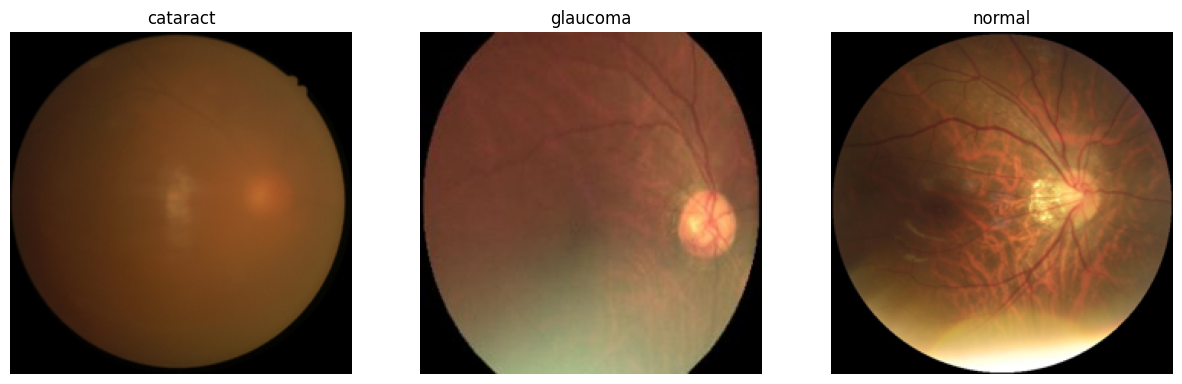

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

def show_sample_images(image_paths, labels):
    unique_labels = np.unique(labels)
    plt.figure(figsize=(15, 7))
    for i, label in enumerate(unique_labels):
        sample_path = np.random.choice(np.array(image_paths)[labels == label])
        image = Image.open(sample_path).resize(target_size)
        plt.subplot(1, len(unique_labels), i + 1)
        plt.imshow(image)
        plt.title(list(label_to_index.keys())[list(label_to_index.values()).index(label)])
        plt.axis('off')
    plt.show()

show_sample_images(train_paths, train_labels)

## 資料增強

In [9]:
import pandas as pd
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 讀取 CSV 檔案
augmentation_csv_path = '/content/drive/MyDrive/Colab Notebooks/eye_diseases/augmentation.csv'
augmentation_rules = pd.read_csv(augmentation_csv_path)

# 定義資料增強函數
def apply_augmentation(image, label):
    rule = augmentation_rules[augmentation_rules['label'] == label].iloc[0]

    if rule['rotate 90'] == 1 and random.choice([True, False]):
        image = image.rotate(90, expand=True)
    if rule['rotate 180'] == 1 and random.choice([True, False]):
        image = image.rotate(180, expand=True)
    if rule['rotate 270'] == 1 and random.choice([True, False]):
        image = image.rotate(270, expand=True)
    if rule['水平翻轉'] == 1 and random.choice([True, False]):
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
    if rule['垂直翻轉'] == 1 and random.choice([True, False]):
        image = image.transpose(Image.FLIP_TOP_BOTTOM)

    return image

# 創建 ImageDataGenerator 並應用資料增強
data_gen_augmented = ImageDataGenerator(
    preprocessing_function=apply_augmentation,
    rescale=1./255
)

# 創建資料生成器
train_data_augmented = data_gen_augmented.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',
    subset='training'  # 用於訓練數據
)

Found 4285 images belonging to 4 classes.


## 可視化 增強後圖片

In [10]:
def show_augmented_samples(generator, num_samples=5):
    plt.figure(figsize=(15, 7))
    for i in range(num_samples):
        image, _ = next(generator)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image[0])
        plt.title(f'Sample {i + 1}')
        plt.axis('off')
    plt.show()

# 顯示經過資料增強後的一些圖片
show_augmented_samples(train_data_augmented)

TypeError: ignored

<Figure size 1500x700 with 0 Axes>

## Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import matplotlib.pyplot as plt

# 定義 DenseNet 模型

def create_densenet_model(num_classes):
    base_model = DenseNet121(weights='imagenet', include_top=False)
    # base_model = DenseNet121(weights='path_to_local_weights_file', include_top=False)  無法下載預訓練的，先去load weight
    # base_model = DenseNet121(weights=None, include_top=False)  直接用初始的

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# 設定超參數
num_classes = len(label_to_index)  # 類別數量等於索引數量
batch_size = 32
epochs = 20

# 創建 DenseNet 模型
model = create_densenet_model(num_classes)

# 編譯模型
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# 設定回調函數
checkpoint = ModelCheckpoint('densenet_model.h5', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(patience=5, verbose=1)
#tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)
# 總之，TensorBoard 幫助您監控模型的訓練過程、可視化模型的性能以及調試模型。您可以根據需要調整上述參數來控制日誌文件的生成方式。

# 訓練模型
history = model.fit(
    train_data_augmented,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_data_generator,  # 假設已經定義了驗證集的資料生成器
    callbacks=[checkpoint, early_stopping, tensorboard]
)

# 繪製訓練和驗證的準確度和損失圖表
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 使用測試集評估模型
test_loss, test_accuracy = model.evaluate(test_data_generator)  # 假設已經定義了測試集的資料生成器
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

#### 查看分錯的圖片

In [ ]:
import numpy as np

# 使用 os.listdir 獲取子目錄，每個子目錄名稱即為一個類別名稱
class_names = os.listdir(data_dir)

# 如果您需要按特定順序排序類別名稱，您可以使用 sorted 函數
class_names = sorted(class_names)

# 初始化一個字典來記錄每個類別的分錯數量
class_miscounts = {class_name: 0 for class_name in class_names}

# 初始化一個列表來記錄分錯的圖片資訊
misclassified_images = []

# 遍歷測試集並進行預測
for i, (images, labels) in enumerate(test_data_generator):
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    for j in range(len(labels)):
        true_label = np.argmax(labels[j])
        predicted_label = predicted_labels[j]

        # 如果預測錯誤，則將分錯數量增加1，並將圖片資訊添加到列表中
        if true_label != predicted_label:
            class_name = class_names[true_label]
            class_miscounts[class_name] += 1
            misclassified_images.append({
                'True_Label': class_name,
                'Predicted_Label': class_names[predicted_label],
                'Image': images[j]  # 如果需要存儲圖片本身，可以這樣做
            })

# 輸出每個類別的分錯數量
for class_name, miscount in class_miscounts.items():
    print(f'Class: {class_name}, Misclassified Count: {miscount}')

# 查看分錯的圖片
for misclassified_image in misclassified_images:
    true_label = misclassified_image['True_Label']
    predicted_label = misclassified_image['Predicted_Label']
    image = misclassified_image['Image']

    # 可以根據需要顯示或儲存分錯的圖片，這裡只是一個示例
    plt.imshow(image)
    plt.title(f'True Label: {true_label}, Predicted Label: {predicted_label}')
    plt.show()

In [ ]:
### 舊版本

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten


# 創建模型
model = Sequential([
    DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    Flatten(),
    Dense(len(unique_labels), activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 訓練模型
batch_size = 32
epochs = 10  # 可根據需要調整

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    # 隨機打亂訓練數據
    train_data = list(zip(train_paths, train_indices))
    random.shuffle(train_data)
    train_paths_shuffled, train_indices_shuffled = zip(*train_data)

    for i in range(0, len(train_paths_shuffled), batch_size):
        batch_paths = train_paths_shuffled[i:i + batch_size]
        batch_indices = train_indices_shuffled[i:i + batch_size]

        batch_images = np.array([apply_augmentation(load_img(path, target_size=target_size), augmentation_dict[unique_labels[index]]) for path, index in zip(batch_paths, batch_indices)])
        batch_labels = to_categorical(batch_indices, num_classes=len(unique_labels))

        model.train_on_batch(batch_images, batch_labels)
